In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import (
    compute_distance_from_homography,
    derive_metric_homography,
)
from src.matching import template_match
from src.measurement_data import load_measurements_from_yaml
from src.utils import load_calibration_json

import pandas as pd
from scipy.stats import pearsonr

import seaborn as sns

## **Functions**

In [3]:
def compute_viewing_angle(H):
    """
    Compute approximate viewing angle from homography.
    Returns angle in degrees.
    """
    H_array = np.array(H)
    # Approximate viewing angle from perspective components
    h31, h32 = H_array[2, 0], H_array[2, 1]
    perspective_magnitude = np.sqrt(h31**2 + h32**2)
    # Convert to degrees (rough approximation)
    viewing_angle = np.degrees(np.arctan(perspective_magnitude))
    return viewing_angle

def compute_scale_factor(H):
    """
    Compute scale factor from homography matrix.
    """
    H_array = np.array(H)
    # Compute the determinant of the 2x2 upper-left submatrix
    det = np.linalg.det(H_array[:2, :2])
    return np.sqrt(np.abs(det))

def compute_aspect_ratio_distortion(H):
    """
    Compute how much the homography stretches differently in x vs y directions.
    """
    H_array = np.array(H)
    A = H_array[:2, :2]
    
    # Compute singular values
    U, S, Vt = np.linalg.svd(A)
    aspect_ratio = S[0] / S[1] if S[1] != 0 else float('inf')
    
    return aspect_ratio

def compute_shear_factor(H):
    """
    Compute shear distortion from homography.
    """
    H_array = np.array(H)
    A = H_array[:2, :2]
    
    det_A = np.linalg.det(A)
    trace_A = np.trace(A)
    
    if det_A != 0:
        shear_factor = abs((trace_A**2 - 4*det_A) / (4*det_A))
    else:
        shear_factor = float('inf')
    
    return shear_factor

def compute_translation_magnitude(H):
    """
    Compute the magnitude of translation component.
    """
    H_array = np.array(H)
    tx, ty = H_array[0, 2], H_array[1, 2]
    return np.sqrt(tx**2 + ty**2)

def compute_perspective_distortion(H):
    """
    Compute perspective distortion magnitude.
    """
    H_array = np.array(H)
    h31, h32 = H_array[2, 0], H_array[2, 1]
    return np.sqrt(h31**2 + h32**2)

def compute_rotation_angle(H):
    """
    Compute approximate rotation angle from homography.
    """
    H_array = np.array(H)
    A = H_array[:2, :2]
    
    # Use SVD to decompose rotation and scaling
    U, S, Vt = np.linalg.svd(A)
    R = U @ Vt  # Rotation matrix
    
    # Extract rotation angle
    rotation_angle = np.degrees(np.arctan2(R[1, 0], R[0, 0]))
    return abs(rotation_angle)

def analyze_all_homographies(all_results):
    """
    Analyze all homographies and return a comprehensive DataFrame.
    
    Args:
        all_results: Dictionary with scene_id as keys, each containing template results
    
    Returns:
        DataFrame with all computed metrics
    """
    analysis_data = []
    
    for scene_id, scene_results in all_results.items():
        for template_id, data in scene_results.items():
            H = data['homography']
            
            # Compute all metrics
            metrics = {
                'scene_id': scene_id,
                'template_id': template_id,
                'distance_error': data['error'],
                'distance_error_percent': data['error_percent'],
                'distance_pred': data['distance_pred'],
                'distance_true': data['distance_true'],
                'condition_number': data['condition_number'],
                'reprojection_error': data['reprojection_error'],
                'viewing_angle': compute_viewing_angle(H),
                'scale_factor': compute_scale_factor(H),
                'aspect_ratio': compute_aspect_ratio_distortion(H),
                'shear_factor': compute_shear_factor(H),
                'translation_magnitude': compute_translation_magnitude(H),
                'perspective_distortion': compute_perspective_distortion(H),
                'rotation_angle': compute_rotation_angle(H),
            }
            
            analysis_data.append(metrics)
    
    return pd.DataFrame(analysis_data)

def compute_correlations_with_error(df, error_column='distance_error_percent'):
    """
    Compute correlations between all metrics and the error column.
    
    Args:
        df: DataFrame from analyze_all_homographies
        error_column: Column name to correlate against (default: percentage error)
    
    Returns:
        Series with correlations sorted by absolute value
    """
    # Select only numeric columns for correlation
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    numeric_columns = numeric_columns.drop('template_id', errors='ignore')
    # Remove absolute distance error from correlations
    numeric_columns = numeric_columns.drop('distance_error', errors='ignore')
    
    correlations = {}
    for col in numeric_columns:
        if col != error_column:
            corr, p_value = pearsonr(df[error_column], df[col])
            correlations[col] = corr
    
    corr_series = pd.Series(correlations)
    return corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

def plot_correlation_heatmap(df, figsize=(12, 10)):
    """
    Plot correlation heatmap of all metrics.
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = numeric_df.drop('template_id', errors='ignore')
    
    plt.figure(figsize=figsize)
    correlation_matrix = numeric_df.corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, fmt='.2f')
    plt.title('Correlation Matrix of Homography Metrics')
    plt.tight_layout()
    plt.show()

def plot_error_vs_metrics(df, error_column='distance_error_percent', top_n=6):
    """
    Plot scatter plots of percentage error vs top correlated metrics.
    """
    correlations = compute_correlations_with_error(df, error_column)
    top_correlations = correlations.head(top_n)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (metric, corr) in enumerate(top_correlations.items()):
        ax = axes[i]
        ax.scatter(df[metric], df[error_column], alpha=0.7)
        ax.set_xlabel(metric)
        ax.set_ylabel(f'{error_column} (%)')
        ax.set_title(f'{metric} vs {error_column}\nCorr: {corr:.3f}')
        
        # Add trend line
        z = np.polyfit(df[metric], df[error_column], 1)
        p = np.poly1d(z)
        ax.plot(df[metric], p(df[metric]), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()

def print_analysis_summary(df):
    """
    Print a summary of the analysis results focusing on percentage error.
    """
    print("=== HOMOGRAPHY ANALYSIS SUMMARY ===")
    print(f"Total templates analyzed: {len(df)}")
    print(f"Mean distance error: {df['distance_error_percent'].mean():.1f}%")
    print(f"Std distance error: {df['distance_error_percent'].std():.1f}%")
    print(f"Min error: {df['distance_error_percent'].min():.1f}%")
    print(f"Max error: {df['distance_error_percent'].max():.1f}%")
    
    print("\n=== TOP CORRELATIONS WITH PERCENTAGE DISTANCE ERROR ===")
    correlations = compute_correlations_with_error(df)
    for metric, corr in correlations.head(10).items():
        print(f"{metric:25s}: {corr:6.3f}")
    
    print("\n=== METRIC RANGES ===")
    metrics_to_show = ['viewing_angle', 'scale_factor', 'aspect_ratio', 
                      'perspective_distortion', 'rotation_angle']
    for metric in metrics_to_show:
        if metric in df.columns:
            print(f"{metric:25s}: {df[metric].min():6.3f} - {df[metric].max():6.3f}")

## **Analysis**

In [4]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

scenes = data.get_all_scenes()

In [5]:
def analyze_scene(scene_id, scenes, K):
    """
    This function analyzes a scene by executing the following steps:

    1. Load the scene and the corresponding templates.
    2. For each template, perform template matching against the scene image.
    3. Compute the homography and recover the camera pose.
    4. Compute the distance from the center of each template to the camera.
    5. Return the results including the template ID, homography, camera pose, and distance.
    """
    # Load scene and templates
    scene = data.get_scene(scene_id)
    templates = [data.get_template(t_id) for t_id in scenes[scene_id]]

    # Iterate over templates
    results = {}
    for template in templates:
        scene_path = os.path.join(project_root, scene.path)
        template_path = os.path.join(project_root, template.path)

        # Compute pixel-pixel homography
        H, mask, t_shape, reprojection_error = template_match(template_path, scene_path, extract_method='SIFT', match_method='BF', plot=False)

        template_size_px = plt.imread(template_path).shape[:2]

        # Derive the metric-pixel homography
        H_metric = derive_metric_homography(
            H_px=H,
            template_size_px=template_size_px,
            template_size_metric=(template.height, template.width)
        )

        # Compute the condition number of the homography
        cond_num = np.linalg.cond(H_metric)

        # Template center point
        template_center_mm = np.array([template.width / 2, template.height / 2])

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance_from_homography(
            H_mm2img=H_metric,
            K=K,
            point_mm=template_center_mm
        )

        # True distance and error
        distance_true = scene.get_distance('Camera', template.id).distance
        error = np.abs(distance_pred - distance_true)
        error_percent = (error / distance_true) * 100

        results[template.id] = {
            'homography': H.tolist(),
            'distance_pred': distance_pred,
            'distance_true': distance_true,
            'error': error,
            'error_percent': error_percent,
            'condition_number': cond_num,
            'reprojection_error': reprojection_error,
        }
    return results

def analyze_scenes(scenes, K):
    """
    Analyze all scenes and return results.
    """
    all_results = {}
    for scene_id in scenes:
        # Skip scene S8
        if scene_id == 'S8':
            continue

        print(f"Analyzing scene {scene_id}...")
        results = analyze_scene(scene_id, scenes, K)
        all_results[scene_id] = results
    return all_results

In [6]:
results = analyze_scenes(scenes, K)

Analyzing scene S0...
Analyzing scene S1...
Analyzing scene S2...
Analyzing scene S3...
Analyzing scene S4...
Analyzing scene S5...
Analyzing scene S6...
Analyzing scene S7...
Analyzing scene S9...
Analyzing scene S10...
Analyzing scene S11...
Analyzing scene S12...
Analyzing scene S13...


=== HOMOGRAPHY ANALYSIS SUMMARY ===
Total templates analyzed: 21
Mean distance error: 4.4%
Std distance error: 4.1%
Min error: 0.3%
Max error: 15.1%

=== TOP CORRELATIONS WITH PERCENTAGE DISTANCE ERROR ===
aspect_ratio             :  0.668
rotation_angle           :  0.535
distance_pred            : -0.532
translation_magnitude    :  0.524
viewing_angle            :  0.512
perspective_distortion   :  0.512
distance_true            : -0.480
reprojection_error       :  0.336
scale_factor             : -0.075
condition_number         : -0.026

=== METRIC RANGES ===
viewing_angle            :  0.001 -  0.021
scale_factor             :  0.179 -  1.339
aspect_ratio             :  1.037 -  2.147
perspective_distortion   :  0.000 -  0.000
rotation_angle           :  0.377 - 158.712


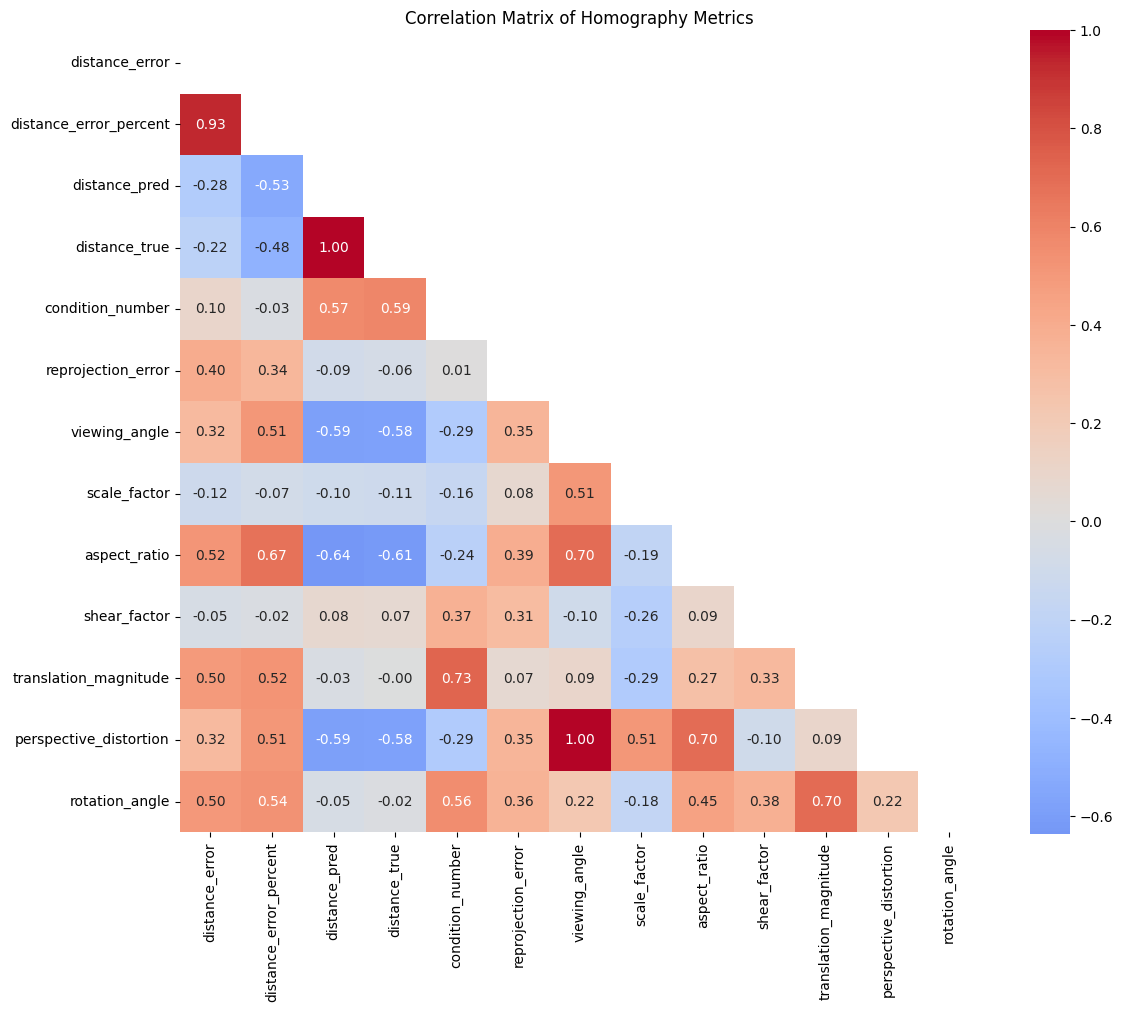

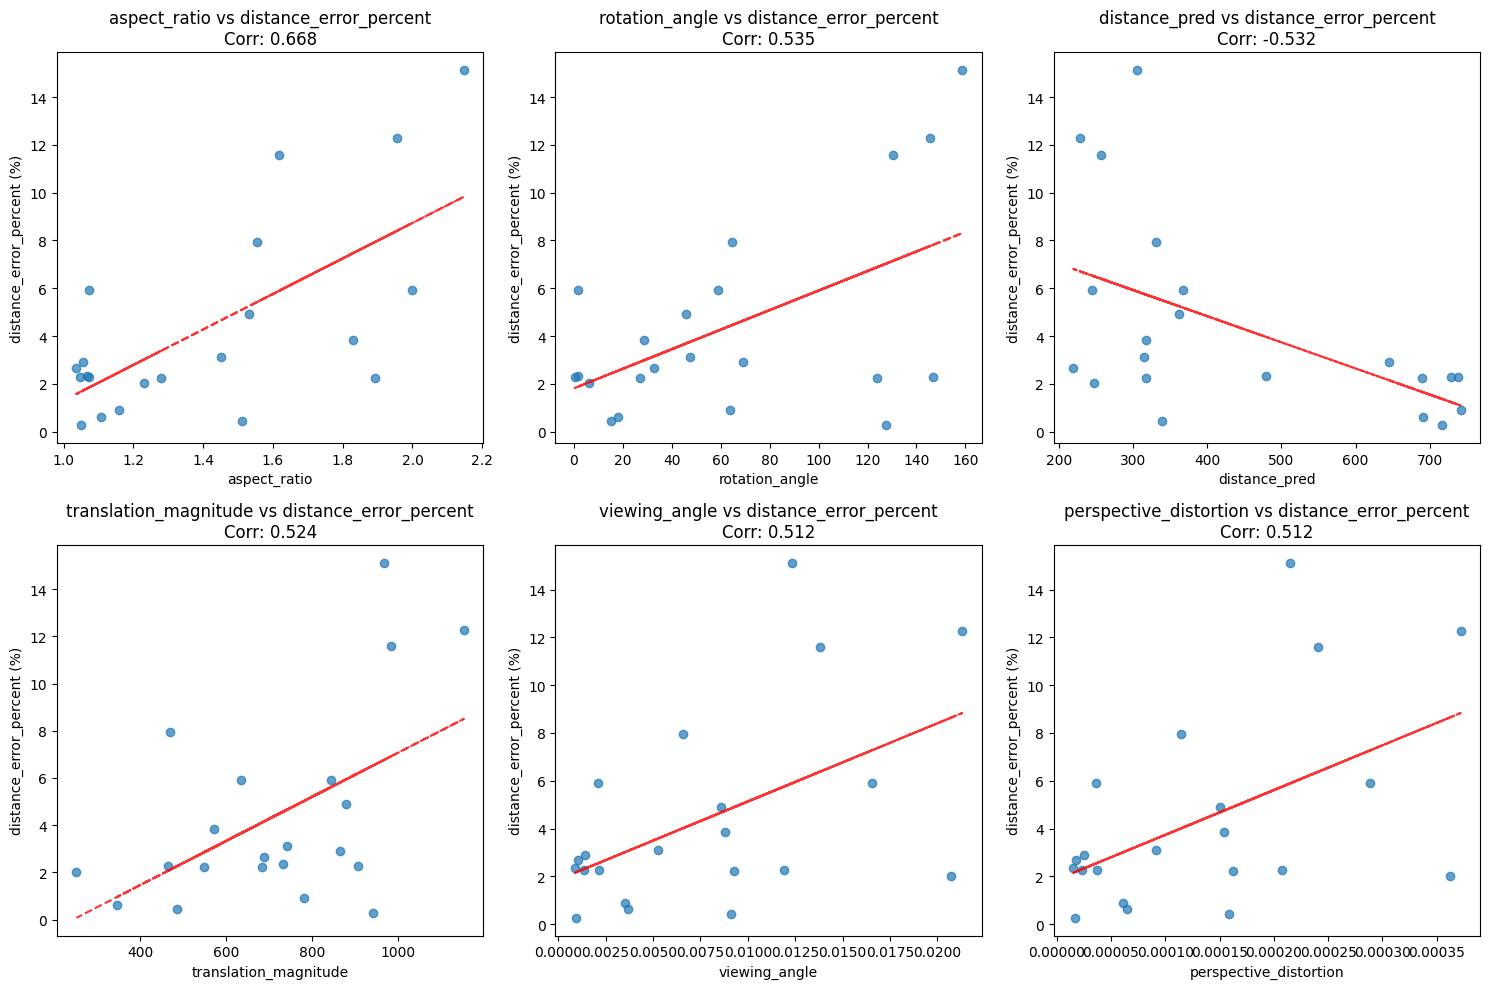


Detailed correlations:
aspect_ratio              0.668133
rotation_angle            0.535414
distance_pred            -0.532483
translation_magnitude     0.523726
viewing_angle             0.512193
perspective_distortion    0.512193
distance_true            -0.479917
reprojection_error        0.336421
scale_factor             -0.074814
condition_number         -0.025773
shear_factor             -0.024633
dtype: float64


In [7]:
# Perform complete analysis
df = analyze_all_homographies(results)

# Print summary
print_analysis_summary(df)

# Plot correlations
plot_correlation_heatmap(df)
plot_error_vs_metrics(df)

# Get detailed correlations
correlations = compute_correlations_with_error(df)
print("\nDetailed correlations:")
print(correlations)